## 高斯混合模型

- 从几何角度来看: 加权平均(多个高斯分布叠加而成) $$ P(x) = \sum^K_{k=1} p_kN(\mu_k,\Sigma_k) \; s.t \sum^K_{k=1} p_k = 1$$

- 从混合模型(生成模型)角度来看: 
    1 掷骰子均订用哪个高斯分布去生成, 也就是隐变量z
    2 再具体高斯分布下采样, 得到样本x

#### EM求解

- 使用西瓜书的求解方式, 定义高斯混合分布, 其中 $ \alpha_i$为第i个混合成分的概率: $$ P(x) = \sum^k_{i=1} \alpha_ip(x|\mu_i,\Sigma_i) \; s.t \sum^K_{i=1} \alpha_i = 1$$

- 令随机变量 $ z_j \in  \{1,k\}$ 表示生成样本 $x_j$ 的高斯混合成分, 其中 $P(z_j=i) = \alpha_i$ 所以隐变量的后验分布为: 

$$ P_M(z_j=i|x_j) = \frac{P(z_j= i )P_M(x_j|z_j=i)}{P_M(x_j)} = \frac{\alpha_i \cdot p(x_j|\mu_i, \Sigma_i)}{\sum^k_{i=1}\alpha_i \cdot p(x_i|\mu_i, \Sigma_i)}$$

- 对模型进行最大对数似然, 可得每个分组权重: $$ \mu_i = \frac{\sum^m_{j=1}\gamma_{ji}x_j}{\sum^m_{j=1}\gamma_{ji}}$$

- 可得每个分组方差: $$ \Sigma_i = \frac{\sum^m_{j=1}\gamma_{ji}(x_j-\mu_i)(x_j-\mu_i)^T}{\sum^m_{j=1}\gamma_{ji}}$$

- 引入拉格朗日求解可得隐变量: $$ \alpha_i = \frac1m\sum^m_{j=1}\gamma_{ji}$$

In [6]:
import numpy as np

class GMM:
    def __init__(self, n_components=3, max_iter=100):
        # k个分组节点
        self.n_components = n_components
        # 最大迭代次数
        self.max_iter = max_iter

    def fit(self, X):
        # 数据量行数, 数据量有多少维度
        n_samples, n_features = X.shape
        # 初始化参数
        # 权重ai默认为1/k
        self.weights = np.ones(self.n_components) / self.n_components
        # 生成k个维度为n的均值
        self.means = np.random.rand(self.n_components, n_features)
        # 生成k个矩阵大小为维度n的单位方差矩阵
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        # 迭代n次
        for _ in range(self.max_iter):
            # E步：计算后验概率
            resp = np.zeros((n_samples, self.n_components))
            for j in range(n_samples):
                for i in range(self.n_components):
                    # 计算高斯分布概率密度函数
                    pdf = self._gaussian_pdf(X[j], self.means[i], self.covariances[i])
                    # 权重 * 高斯模型概率
                    resp[j, i] = self.weights[i] * pdf
                # 每个样本的后验需要除以分组的后验合计
                resp[j] /= resp[j].sum()

            # M步：更新参数
            
            # 后验概率求和
            Nk = resp.sum(axis=0)
            # 更新ai
            self.weights = Nk / n_samples
             # 分组更新均值核方差
            for k in range(self.n_components):
                self.means[k] = np.dot(resp[:, k], X) / Nk[k]
                self.covariances[k] = np.dot(resp[:, k] * (X - self.means[k]).T, X - self.means[k]) / Nk[k]

    def _gaussian_pdf(self, x, mean, cov):
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        n = x.shape[0]
        diff = x - mean
        return np.exp(-0.5 * np.dot(np.dot(diff.T, inv), diff)) / (np.sqrt((2 * np.pi)**n * det))

    def predict(self, X):
        resp = np.zeros((X.shape[0], self.n_components))
        for i in range(X.shape[0]):
            for k in range(self.n_components):
                pdf = self._gaussian_pdf(X[i], self.means[k], self.covariances[k])
                resp[i, k] = self.weights[k] * pdf
            resp[i] /= resp[i].sum()
        return np.argmax(resp, axis=1)

[[ 2.74403536 -3.21361048]
 [-0.08270665 -0.0792566 ]
 [ 2.9844215   2.78546138]]


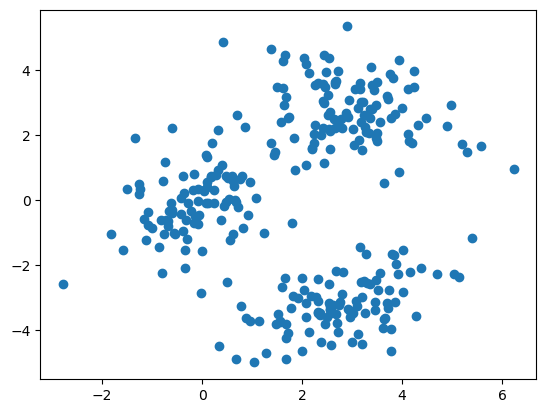

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gmm_data(K, N, means, covs):
    """
    生成高斯混合模型数据

    Args:
        K: 高斯分布的数量
        N: 每个高斯分布生成的样本数
        means: 各个高斯分布的均值向量
        covs: 各个高斯分布的协方差矩阵

    Returns:
        生成的样本数据
    """

    data = np.zeros((N*K, means.shape[1]))
    for k in range(K):
        data[k*N:(k+1)*N, :] = np.random.multivariate_normal(means[k], covs[k], N)
    return data

# 示例：生成一个包含两个二维高斯分布的数据集
K = 3
N = 100
means = np.array([[0, 0], [3, 3], [3,-3]])
covs = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[1, 0.5], [0.5, 1]]])
data = generate_gmm_data(K, N, means, covs)

gmm = GMM()

theta = gmm.fit(data)
print(gmm.means)
# 可视化数据
plt.scatter(data[:, 0], data[:, 1])
plt.show()